In [13]:
import pandas as pd
import numpy as np

class Backtester:
    def __init__(self, data, initial_capital=100000):
        self.data = data.copy()
        self.initial_capital = initial_capital
        self.data['Position'] = 0
        self.data['Cash'] = initial_capital
        self.data['Holdings'] = 0
        self.data['Total'] = initial_capital
        self.trades = []
        self.metrics = {}

    def add_indicator(self, indicator_function, *args, **kwargs):
        self.data = indicator_function(self.data, *args, **kwargs)

    def generate_signals(self, signal_function, *args, **kwargs):
        self.data = signal_function(self.data, *args, **kwargs)

    def simulate_trades(self, 
                        position_sizing_function=None,
                        leverage_function=None,
                        stop_loss_function=None,
                        take_profit_function=None,
                        slippage=0.0,
                        commission=0.0):
        position = 0
        cash = self.initial_capital
        holdings = 0
        total = self.initial_capital
        shares = 0
        entry_price = 0.0
        stop_loss_price = np.nan
        take_profit_price = np.nan
        
        for i in range(len(self.data)):
            date = self.data.index[i]
            price = self.data['Close'].iloc[i]
            row = self.data.iloc[i]
            
            # Entry and exit signals
            entry_signal = row.get('Entry_Signal', 0)
            exit_signal = row.get('Exit_Signal', 0)
            
            # Leverage
            leverage = leverage_function(row) if leverage_function else 1.0
            
            if position == 0 and entry_signal == 1:
                # Determine position size
                position_size = position_sizing_function(row) if position_sizing_function else 1.0
                # Buy
                shares = (cash * position_size * leverage) / price
                holdings = shares * price
                cash -= holdings + commission
                entry_price = price
                # Stop loss and take profit
                stop_loss_price = stop_loss_function(row, entry_price) if stop_loss_function else np.nan
                take_profit_price = take_profit_function(row, entry_price) if take_profit_function else np.nan
                position = 1
                self.trades.append({'Date': date, 'Type': 'Buy', 'Price': price, 'Shares': shares})
            elif position == 1:
                # Check for exit conditions
                exit_trade = False
                if stop_loss_function and price <= stop_loss_price:
                    exit_trade = True
                if take_profit_function and price >= take_profit_price:
                    exit_trade = True
                if exit_signal == -1:
                    exit_trade = True
                if exit_trade:
                    # Sell
                    cash += shares * price - commission
                    holdings = 0
                    pnl = (price - entry_price) * shares
                    self.data.at[date, 'PnL'] = pnl
                    self.trades.append({'Date': date, 'Type': 'Sell', 'Price': price, 'Shares': shares})
                    position = 0
                    shares = 0
                    entry_price = 0.0
                    stop_loss_price = np.nan
                    take_profit_price = np.nan
                else:
                    # Update holdings value
                    holdings = shares * price
            # Update total equity
            total = cash + holdings
            self.data.at[date, 'Position'] = position
            self.data.at[date, 'Cash'] = cash
            self.data.at[date, 'Holdings'] = holdings
            self.data.at[date, 'Total'] = total


    def calculate_metrics(self):
        # Compute returns
        self.data['Returns'] = self.data['Total'].pct_change().fillna(0)
        total_return = (self.data['Total'].iloc[-1] / self.initial_capital) - 1
        
        # Number of trades
        num_trades = len(self.trades) // 2  # Each complete trade has a buy and a sell
        
        # Calculate profits and losses
        profits = []
        for i in range(1, len(self.trades), 2):
            buy = self.trades[i - 1]
            sell = self.trades[i]
            pnl = (sell['Price'] - buy['Price']) * sell['Shares']
            profits.append(pnl)
        
        wins = [p for p in profits if p > 0]
        losses = [p for p in profits if p <= 0]
        win_rate = len(wins) / len(profits) if profits else 0
        avg_return_per_trade = np.mean(profits) if profits else 0
        
        # Max drawdown
        cumulative_returns = self.data['Total'] / self.initial_capital
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Sharpe ratio
        sharpe_ratio = (self.data['Returns'].mean() / self.data['Returns'].std()) * np.sqrt(252)
        
        self.metrics = {
            'Total Return': total_return,
            'Number of Trades': num_trades,
            'Win Rate': win_rate,
            'Average Return per Trade': avg_return_per_trade,
            'Max Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio
        }

    def plot_results(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,6))
        plt.plot(self.data.index, self.data['Total'], label='Portfolio Value')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_trades(self):
        import matplotlib.pyplot as plt
        import mplfinance as mpf

        # Prepare the OHLC data
        ohlc = self.data[['Open', 'High', 'Low', 'Close']]

        # Prepare buy and sell signals
        buys = [(t['Date'], t['Price']) for t in self.trades[::2]]  # Even indices are buys
        sells = [(t['Date'], t['Price']) for t in self.trades[1::2]]  # Odd indices are sells

        # Create the plot
        fig, ax = plt.subplots(figsize=(12, 6))
        mpf.plot(ohlc, type='candle', style='yahoo', ax=ax)

        # Add buy and sell markers
        for date, price in buys:
            ax.plot(date, price, '^', color='g', markersize=10)
        for date, price in sells:
            ax.plot(date, price, 'v', color='r', markersize=10)

        plt.title('OHLC Chart with Entry and Exit Points')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend(['Entry', 'Exit'])
        plt.grid(True)
        plt.show()


In [14]:
def calculate_avwap(data, anchor_dates):
    data = data.copy()
    data['Anchored_VWAP'] = np.nan
    
    for i in range(len(anchor_dates)):
        start_date = anchor_dates[i]
        end_date = anchor_dates[i+1] if i+1 < len(anchor_dates) else data.index[-1]
        period_data = data.loc[start_date:end_date]
        price_volume = (period_data['Close'] * period_data['Volume']).cumsum()
        cumulative_volume = period_data['Volume'].cumsum()
        period_vwap = price_volume / cumulative_volume
        data.loc[start_date:end_date, 'Anchored_VWAP'] = period_vwap
    
    return data

def calculate_adx(data, period=14):
    data = data.copy()
    # Calculate price differences
    data['UpMove'] = data['High'] - data['High'].shift(1)
    data['DownMove'] = data['Low'].shift(1) - data['Low']
    
    # Initialize +DM and -DM
    data['+DM'] = np.where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), data['UpMove'], 0)
    data['-DM'] = np.where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), data['DownMove'], 0)
    
    # Calculate True Range (TR)
    data['High-Low'] = data['High'] - data['Low']
    data['High-Close'] = np.abs(data['High'] - data['Close'].shift(1))
    data['Low-Close'] = np.abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    
    # Smooth the TR, +DM, -DM
    data['TR'+str(period)] = data['TR'].rolling(window=period).sum()
    data['+DM'+str(period)] = data['+DM'].rolling(window=period).sum()
    data['-DM'+str(period)] = data['-DM'].rolling(window=period).sum()
    
    # Calculate +DI and -DI
    data['+DI'+str(period)] = 100 * (data['+DM'+str(period)] / data['TR'+str(period)])
    data['-DI'+str(period)] = 100 * (data['-DM'+str(period)] / data['TR'+str(period)])
    
    # Calculate DX and ADX
    data['DX'] = 100 * (np.abs(data['+DI'+str(period)] - data['-DI'+str(period)]) / 
                        (data['+DI'+str(period)] + data['-DI'+str(period)]))
    data['ADX'] = data['DX'].rolling(window=period).mean()
    
    return data


In [15]:
def generate_signals(data):
    data = data.copy()
    data['Entry_Signal'] = 0
    data['Exit_Signal'] = 0
    
    # Entry condition: Price crosses above Anchored VWAP and ADX > 25
    data['Entry_Signal'] = np.where(
        (data['Close'] > data['Anchored_VWAP']) & 
        (data['Close'].shift(1) <= data['Anchored_VWAP'].shift(1)) &
        (data['ADX'] > 25), 1, 0)
    
    # Exit condition: Price crosses below Anchored VWAP or ADX < 20
    data['Exit_Signal'] = np.where(
        (data['Close'] < data['Anchored_VWAP']) |
        (data['ADX'] < 20), -1, 0)
    
    return data

def leverage_function(row):
    ADX = row['ADX']
    if ADX < 20:
        return 1.0
    elif ADX > 50:
        return 5.0
    else:
        return 1 + (ADX - 20) / (50 - 20) * (5 - 1)

def stop_loss_function(row, entry_price):
    return entry_price * 0.93  # 7% stop loss

def trailing_stop_function(row, entry_price):
    return entry_price * 0.99  # 1% trailing stop


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_89915/1040210170.py:122: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (self.data['Returns'].mean() / self.data['Returns'].std()) * np.sqrt(252)


Total Return: 0.0
Number of Trades: 0
Win Rate: 0
Average Return per Trade: 0
Max Drawdown: 0.0
Sharpe Ratio: nan


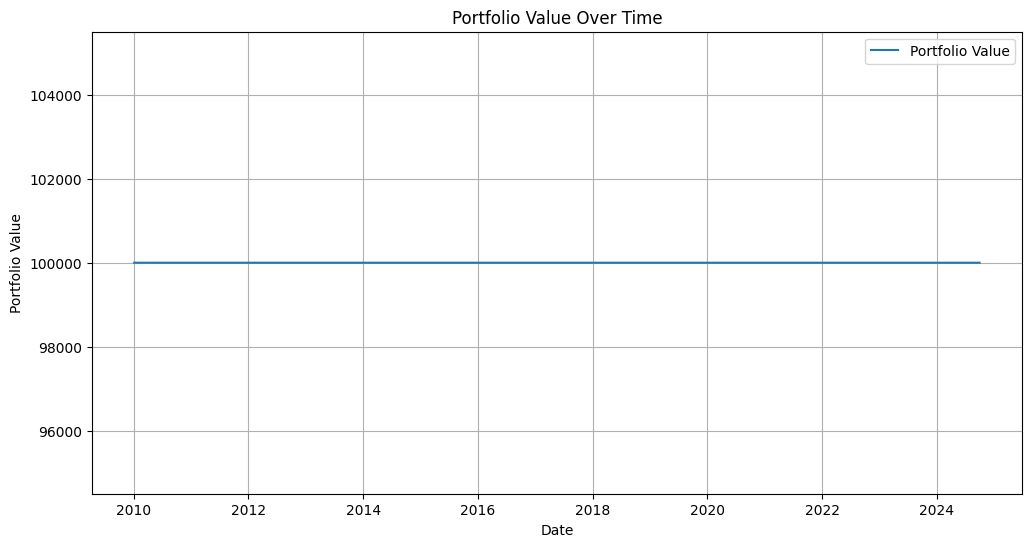

/home/supercoder/Repos/Trading-Strategies/venv/lib/python3.8/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


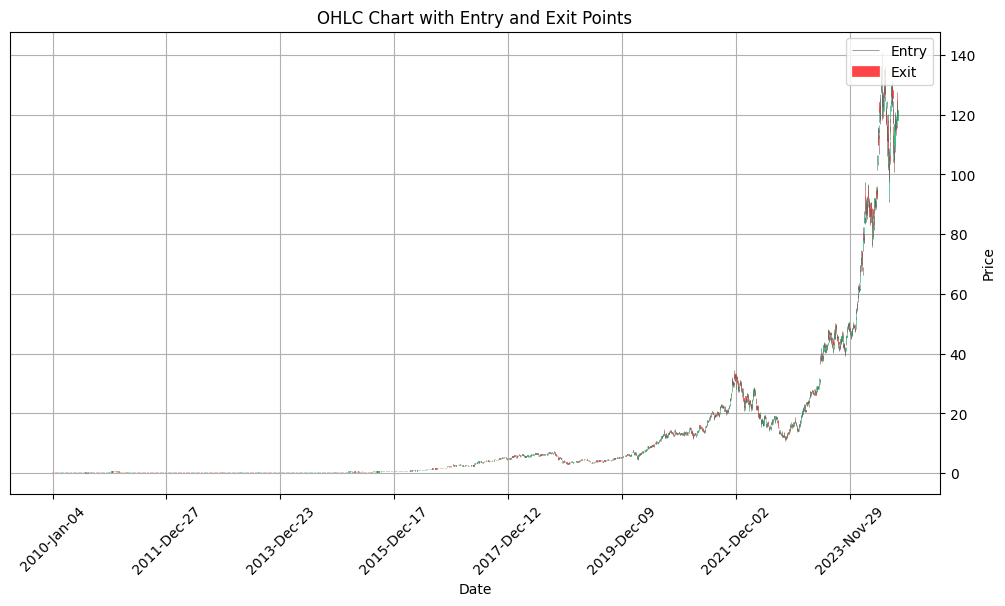

In [16]:
import yfinance as yf

# Download NVDA data
ticker = "NVDA"
data = yf.download(ticker, start="2010-01-01", end="2024-10-01")


# Define anchor dates for Anchored VWAP
anchor_dates = ['2020-02-28', '2020-05-31', '2020-11-30']  # Example dates

# Initialize backtester
backtester = Backtester(data)

# Add indicators
backtester.add_indicator(calculate_avwap, anchor_dates=anchor_dates)
backtester.add_indicator(calculate_adx, period=56)

# Generate signals
backtester.generate_signals(generate_signals)

# Simulate trades
backtester.simulate_trades(
    leverage_function=leverage_function,
    stop_loss_function=stop_loss_function,
    take_profit_function=trailing_stop_function,
    commission=0.0  # Adjust commission if needed
)

# Calculate performance metrics
backtester.calculate_metrics()

# Print metrics
for key, value in backtester.metrics.items():
    print(f"{key}: {value}")

# Plot results
backtester.plot_results()

backtester.plot_trades()
